In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [84]:
bjd, flux, err, x, y, fwhmx, fwhmy, bg, exptime = np.loadtxt('gj1214_channel1.tsv', skiprows=475, unpack=True)
jd = bjd + 2450000

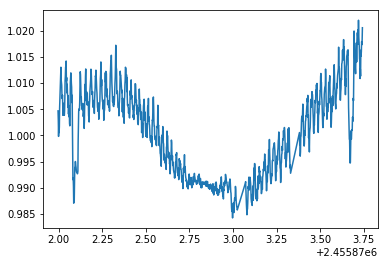

In [85]:
plt.plot(jd, flux)

In [86]:
from batman import TransitParams
params = TransitParams()
params.per = 1.58040417
params.t0 = 2454980.74900
params.inc = 88.47
params.a = 14.45
params.rp = (1.342/100)**0.5 #0.1160
params.duration = 0.03620
params.b = 0.385
params.limb_dark = 'quadratic'
params.u = [0.204, -0.77]
params.w = 90
params.ecc = 0

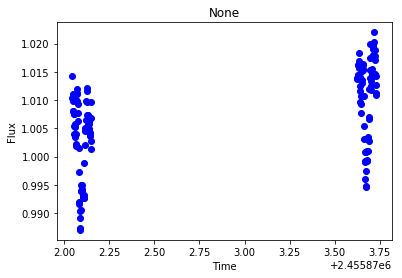

In [93]:
split.plot()

In [97]:
split.get_transit_light_curves(params)

[]

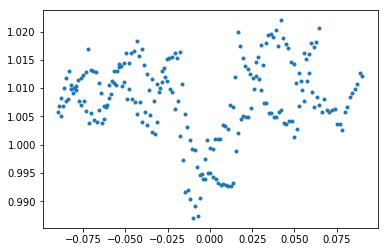

In [104]:
import sys
from astropy.time import Time
sys.path.insert(0, '/Users/bmmorris/git/friedrich/')
from friedrich.lightcurve import LightCurve, concatenate_transit_light_curves

lc = LightCurve(Time(jd, format='jd'), flux)
split = LightCurve(**lc.mask_out_of_transit(params, oot_duration_fraction=2))
#transits = split.get_transit_light_curves(params)
all_transits = split #concatenate_transit_light_curves(transits)

for transit in transits:
#     transit.fluxes /= np.median(transit_masked['fluxes'])

    condition = np.in1d(jd, transit.times.jd)
    
    X_all = np.vstack([x[condition], y[condition], 
                       x[condition]**2, y[condition]**2,
                       fwhmx[condition], 
                       fwhmy[condition], bg[condition]]).T

    oot = np.ones_like(x[condition]).astype(bool)
    X = X_all[oot, :]

    omega = np.diag(err[oot]**2)
    omega_inv = np.linalg.inv(omega)

    V = np.linalg.inv(X.T @ omega_inv @ X)
    beta = V @ X.T @ omega_inv @ transit.fluxes[oot]

    regressed_lc = transit.fluxes - (X_all @ beta) + 1
    
    transit.fluxes = regressed_lc
    transit_masked = transit.mask_in_transit(params)
    transit.fluxes /= np.median(transit_masked['fluxes'])
    
#     transit.plot()
#all_transits = concatenate_transit_light_curves(transits)

times = ((all_transits.times.jd - params.t0) % params.per)
times[times > params.per/2] -= params.per
all_fluxes = all_transits.fluxes[np.argsort(times)]
times = times[np.argsort(times)]
plt.plot(times, all_fluxes, '.')

In [101]:
from copy import deepcopy
import batman

def transit_model(theta, x):
    r0, r1, f0, lnf = theta
    trial_params = deepcopy(params)
    trial_params.t0 = 0
    trial_params.rp0 = r0
    trial_params.rp1 = r1
    
    m = batman.TransitModel(trial_params, x, 
                            supersample_factor=2, 
                            exp_time=np.median(exptime)/60/60/24)
    fluxes = f0 * m.light_curve(trial_params)
    
    return fluxes
    
def lnlike(theta, x, y, yerr):
    r0, r1, f0, lnf = theta

    model = transit_model(theta, x) 
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((model - all_fluxes)**2 *inv_sigma2 - np.log(inv_sigma2)))

#     return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    r0, r1, f0, lnf = theta
    if 0 < r0 < 1 and 0.0 < r1 < 1 and 0 < f0 < 2:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


ndim, nwalkers = 4, 10
#pos = [[params.rp, params.rp, 0] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
pos = []

while len(pos) < nwalkers: 
    trial_pos = [params.rp, params.rp, 1, 0] + 1e-2*np.random.randn(ndim)
    if np.isfinite(lnprior(trial_pos)):
        pos.append(trial_pos)

import emcee
yerr = np.ones_like(all_fluxes) * all_fluxes.std()/2
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(times, all_fluxes, yerr),
                                threads=4)

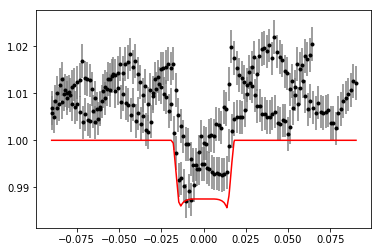

In [102]:
init_f = transit_model([params.rp, params.rp, 1, 1], times)

plt.errorbar(times, all_fluxes, yerr, fmt='.', color='k', ecolor='gray')
plt.plot(times, init_f, 'r', zorder=10)

In [50]:
sampler.run_mcmc(pos, 10000); 

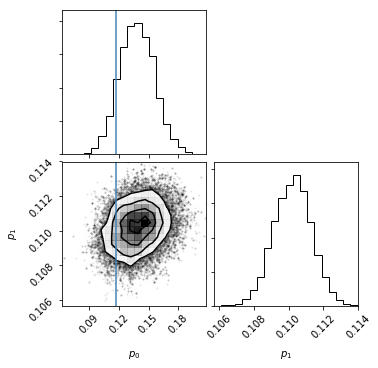

In [53]:
from corner import corner

nburnin = 5000
corner(sampler.chain[:, 5000:, :2].reshape((-1, ndim-2)), truths=[params.rp, params.rp], 
       labels=['$p_0$', '$p_1$']);

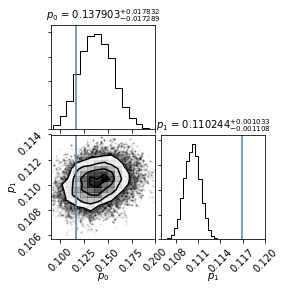

In [54]:
from corner import corner

nburnin = 5000
fig, ax = plt.subplots(2, 2, figsize=(4, 4))
corner(sampler.chain[:, 5000:, :2].reshape((-1, ndim-2)), truths=[params.rp, params.rp], 
       labels=['$p_0$', '$p_1$'], fig=fig, show_titles=True, title_fmt='.6f', title_kwargs=dict(fontsize=10));

for i, axis in enumerate(fig.axes):
    axis.set_xlim([0.09, 0.2])
    if i == 3: 
        axis.set_xlim([0.106, 0.12])
plt.savefig('corner_quad_gj1214.pdf', bbox_inches='tight')

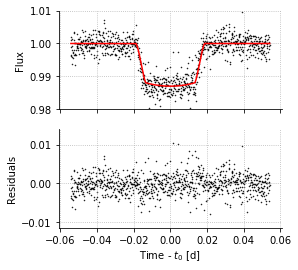

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
ax[0].scatter(times, all_fluxes, marker='.', s=1, 
              color='k')

i = np.argmax(sampler.flatlnprobability, axis=0)
ax[0].plot(times, transit_model(sampler.flatchain[i, :], times), color='r')

ax[1].scatter(times, all_fluxes - transit_model(sampler.flatchain[i, :], times), 
              marker='.', s=1, 
              color='k')

ax[0].set_ylim([0.98, 1.01])
#ax[1].set_ylim([-1000, 1000])

ax[0].set_ylabel('Flux')
ax[1].set(xlabel='Time - $t_0$ [d]', ylabel='Residuals')

for axis in ax:
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    axis.grid(ls=':')

fig.savefig('gj1214_residuals.pdf', bbox_inches='tight', dpi=250)

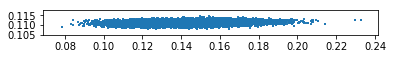

In [11]:
plt.scatter(sampler.chain[:, 5000:, 0], sampler.chain[:, 5000:, 1], marker=',', s=1)
plt.gca().set_aspect(1)

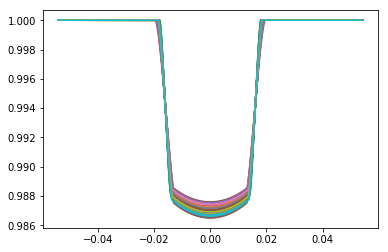

In [13]:


for i in np.random.randint(5000-sampler.chain.shape[0], size=10):
    samples_i = sampler.chain[:, (5000+i), :]
    for sample in samples_i: 
        plt.plot(times, transit_model(sample, times))